In [1]:
import pandas as pd

In [2]:
fact_table = pd.read_csv('./Datasets/Fact_Dimension_tables/FactTable.csv', encoding='ISO-8859-1', header=0)

Sales and Revenue Analysis:

In [3]:
# Monthly Sales Analysis
Sale_data = fact_table.copy(deep=False)
monthly_sales = Sale_data.groupby(['Order Year', 'Order Month'])['Sales'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['Sales'] = monthly_sales['Sales'].map('£{:,.2f}'.format)
#monthly_sales
# Yearly Revenue Analysis
#fact_table
yearly_revenue = Sale_data.groupby('Order Year')['Sales'].sum()
yearly_revenue = yearly_revenue.map('£{:,.2f}'.format)
# Profit Margin Calculation
Sale_data['Profit Margin'] = (Sale_data['Benefit per order'] / Sale_data['Sales']) * 100

# Print results
print("Monthly Sales:")
print(monthly_sales)

print("\nYearly Revenue:")
print(yearly_revenue)

print("\nProfit Margin:")
print(Sale_data[['Order Year', 'Order Month', 'Profit Margin']])

with pd.ExcelWriter('./Results/sales_analysis.xlsx') as writer:
    # Save Monthly Sales DataFrame to a sheet named 'Monthly Sales'
    monthly_sales.to_excel(writer, sheet_name='Monthly Sales', index=False)

    # Save Yearly Revenue DataFrame to a sheet named 'Yearly Revenue'
    pd.DataFrame({'Yearly Revenue': yearly_revenue}).to_excel(writer, sheet_name='Yearly Revenue', index=True)

    # Save Profit Margin DataFrame to a sheet named 'Profit Margin'
    Sale_data[['Order Year', 'Order Month', 'Profit Margin']].to_excel(writer, sheet_name='Profit Margin', index=False)

print("DataFrames saved to sales_analysis.xlsx with multiple sheets.")

Monthly Sales:
    Order Year  Order Month          Sales
0         2015            1  £1,051,590.08
1         2015            2    £927,009.90
2         2015            3  £1,051,253.69
3         2015            4  £1,014,463.28
4         2015            5  £1,050,478.44
5         2015            6  £1,024,006.17
6         2015            7  £1,038,081.19
7         2015            8  £1,029,494.69
8         2015            9  £1,018,338.60
9         2015           10  £1,049,154.27
10        2015           11  £1,029,120.24
11        2015           12  £1,057,840.88
12        2016            1  £1,046,308.25
13        2016            2    £968,542.85
14        2016            3  £1,025,853.12
15        2016            4  £1,001,211.58
16        2016            5  £1,029,400.20
17        2016            6  £1,003,059.55
18        2016            7  £1,045,715.62
19        2016            8  £1,048,200.25
20        2016            9  £1,002,397.04
21        2016           10  £1,048,130

Delivery Performance:

In [4]:
# Average Delivery Time
average_delivery_time = fact_table.groupby('Delivery Status')['Days for shipment (scheduled)'].mean()

# On-time Delivery Rate
on_time_delivery_rate = fact_table['Late_delivery_risk'].mean() * 100

# Print results
print("Average Delivery Time:")
print(average_delivery_time)

print("\nOn-time Delivery Rate:")
print(on_time_delivery_rate)

Average Delivery Time:
Delivery Status
Advance shipping     4.000000
Late delivery        2.471069
Shipping canceled    2.903921
Shipping on time     2.975214
Name: Days for shipment (scheduled), dtype: float64

On-time Delivery Rate:
54.82913155955883


In [5]:
fact_table.columns

Index(['Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Customer Id', 'Latitude', 'Longitude',
       'order date (DateOrders)', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Product Name', 'Product Price',
       'Product Status', 'Market_Id', 'Del_Status_Id', 'Ship_Mode_id',
       'Cust_Country_Id', 'Cust_City_Id', 'Cust_Seg_Id', 'Pay_Type_Id',
       'Dep_Id', 'Ord_Cty_Id', 'Ord_Ctry_Id', 'Ctg_Name_Id', 'Order Year',
       'Order Month'],
      dtype='object')

RFM Analysis

In [6]:
supply_dataset = fact_table.copy(deep=False)
# Start Date and Last Date of Order
supply_dataset['order date (DateOrders)'].min(), supply_dataset['order date (DateOrders)'].max()

('2015-01-01 00:00:00', '2018-01-31 23:38:00')

In [7]:
# formatting order date into pandas datetime validation
supply_dataset['order date (DateOrders)'] = pd.to_datetime(supply_dataset['order date (DateOrders)'])

In [8]:
supply_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Days for shipping (real)       180519 non-null  int64         
 1   Days for shipment (scheduled)  180519 non-null  int64         
 2   Benefit per order              180519 non-null  float64       
 3   Sales per customer             180519 non-null  float64       
 4   Delivery Status                180519 non-null  object        
 5   Late_delivery_risk             180519 non-null  int64         
 6   Customer Id                    180519 non-null  int64         
 7   Latitude                       180519 non-null  float64       
 8   Longitude                      180519 non-null  float64       
 9   order date (DateOrders)        180519 non-null  datetime64[ns]
 10  Order Item Discount            180519 non-null  float64       
 11  

In [9]:
supply_dataset['Order Price'] = supply_dataset['Order Item Quantity'] * supply_dataset['Product Price']

In [10]:
from datetime import datetime
Present_Date = datetime(2017, 9, 10)
RFM = supply_dataset.groupby('Customer Id').agg({'order date (DateOrders)': lambda date:(Present_Date-date.max()).days,
                                                'Order Item Quantity':lambda num:len(num),
                                           'Order Price':lambda price:price.sum()})

RFM.columns

Index(['order date (DateOrders)', 'Order Item Quantity', 'Order Price'], dtype='object')

In [11]:
# Change Column Names 
RFM.columns = ['monetary','frequency','recency']


In [12]:
RFM['recency'] = RFM['recency'].astype(int)
RFM[RFM['monetary']<0]=0

In [13]:
RFM = RFM.drop_duplicates()

In [14]:
RFM['r_quartile'] = pd.qcut(RFM['recency'], 4, ['1','2','3','4'])
RFM['f_quartile'] = pd.qcut(RFM['frequency'], 4, ['4','3','2','1'])
RFM['m_quartile'] = pd.qcut(RFM['monetary'], 4, ['4','3','2','1'])

In [15]:
RFM.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile
Customer Id,,,,,,
1,648,1,499,1,4,1
2,0,0,0,1,4,4
3,85,18,3537,3,2,3
4,236,14,1719,2,2,2
5,313,7,1274,1,4,1


In [16]:
RFM['RFM_Score'] = RFM.r_quartile.astype(str)+ RFM.f_quartile.astype(str) + RFM.m_quartile.astype(str)
RFM.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
Customer Id,,,,,,,
1,648,1,499,1,4,1,141
2,0,0,0,1,4,4,144
3,85,18,3537,3,2,3,323
4,236,14,1719,2,2,2,222
5,313,7,1274,1,4,1,141


Top/Best cusotmers Based on RFM Analysis

In [17]:
# Filter out Top/Best cusotmers
RFM.sort_values(['RFM_Score'],axis=0, ascending=True).head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
Customer Id,,,,,,,
4913,391,14,1580,1,2,1,121
3353,171,14,1489,1,2,2,122
11324,341,10,1639,1,3,1,131
9274,420,10,1613,1,3,1,131
8317,354,10,1594,1,3,1,131


Time Series Analysis

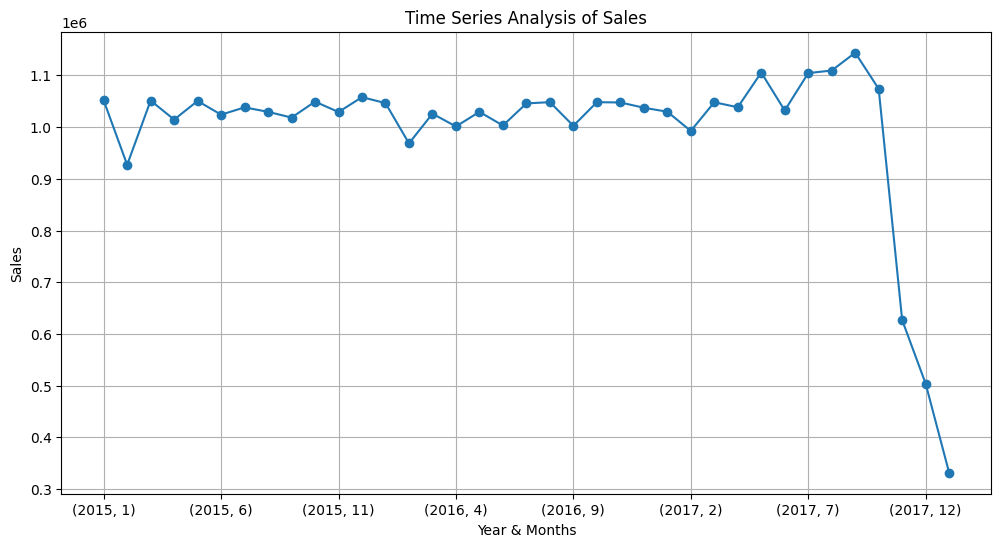

In [18]:
import matplotlib.pyplot as plt

# Time Series Analysis of Sales
time_series_sales = fact_table.groupby(['Order Year','Order Month'])['Sales'].sum()

# Plotting Time Series Sales
plt.figure(figsize=(12, 6))
time_series_sales.plot(marker='o')
plt.title('Time Series Analysis of Sales')
plt.xlabel('Year & Months')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

C:\Users\thota\AppData\Local\Temp\ipykernel_22916\641516782.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


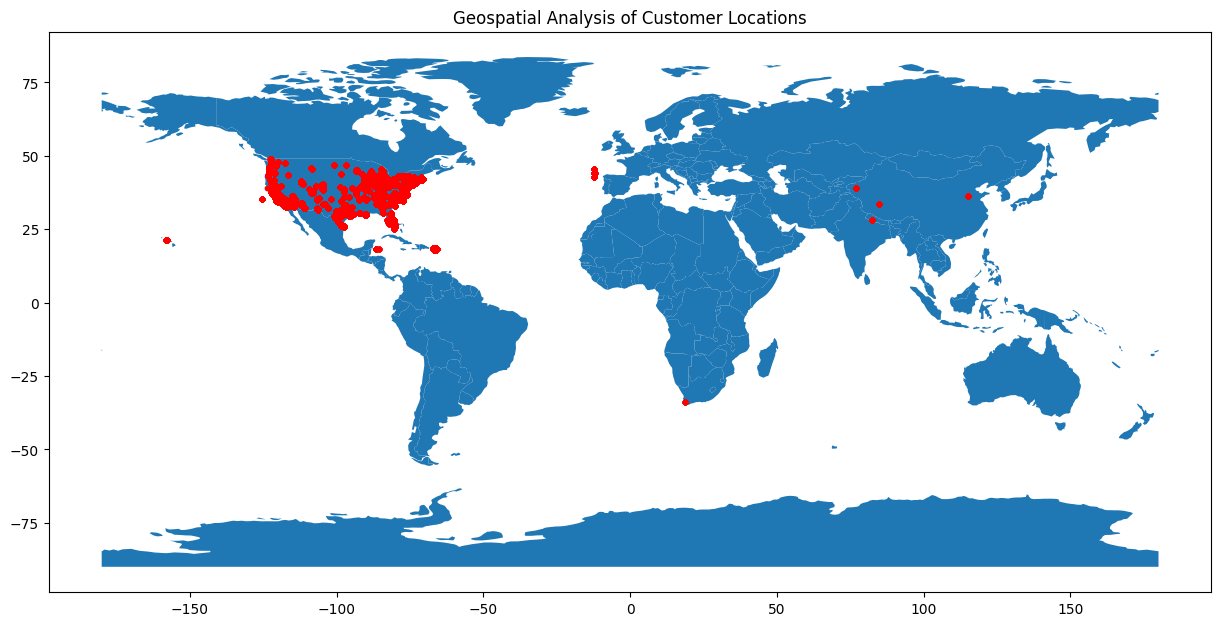

In [19]:
import geopandas as gpd

# Geospatial Analysis of Customer Locations
# Assuming you have latitude and longitude columns in the dataset
gdf = gpd.GeoDataFrame(fact_table, geometry=gpd.points_from_xy(fact_table['Longitude'], fact_table['Latitude']))

# Plotting Customer Locations on a Map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 10))
gdf.plot(ax=ax, color='red', markersize=10)
plt.title('Geospatial Analysis of Customer Locations')
plt.show()